In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("ev_charging_patterns.csv")

# Display the first few rows
df.head()

# Check for missing values
df.isnull().sum()

# Get dataset information
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 20 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   User ID                                   1320 non-null   object 
 1   Vehicle Model                             1320 non-null   object 
 2   Battery Capacity (kWh)                    1320 non-null   float64
 3   Charging Station ID                       1320 non-null   object 
 4   Charging Station Location                 1320 non-null   object 
 5   Charging Start Time                       1320 non-null   object 
 6   Charging End Time                         1320 non-null   object 
 7   Energy Consumed (kWh)                     1254 non-null   float64
 8   Charging Duration (hours)                 1320 non-null   float64
 9   Charging Rate (kW)                        1254 non-null   float64
 10  Charging Cost (USD)                 

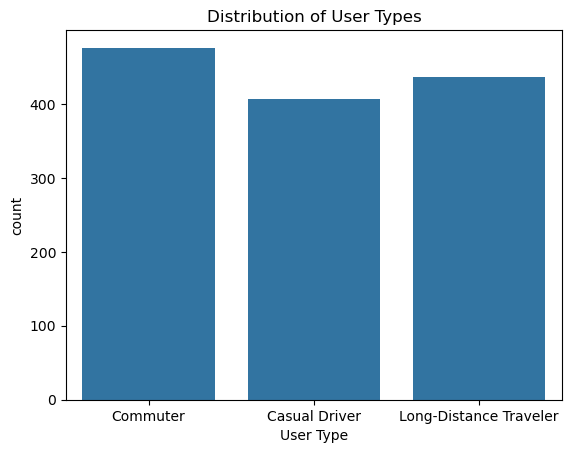

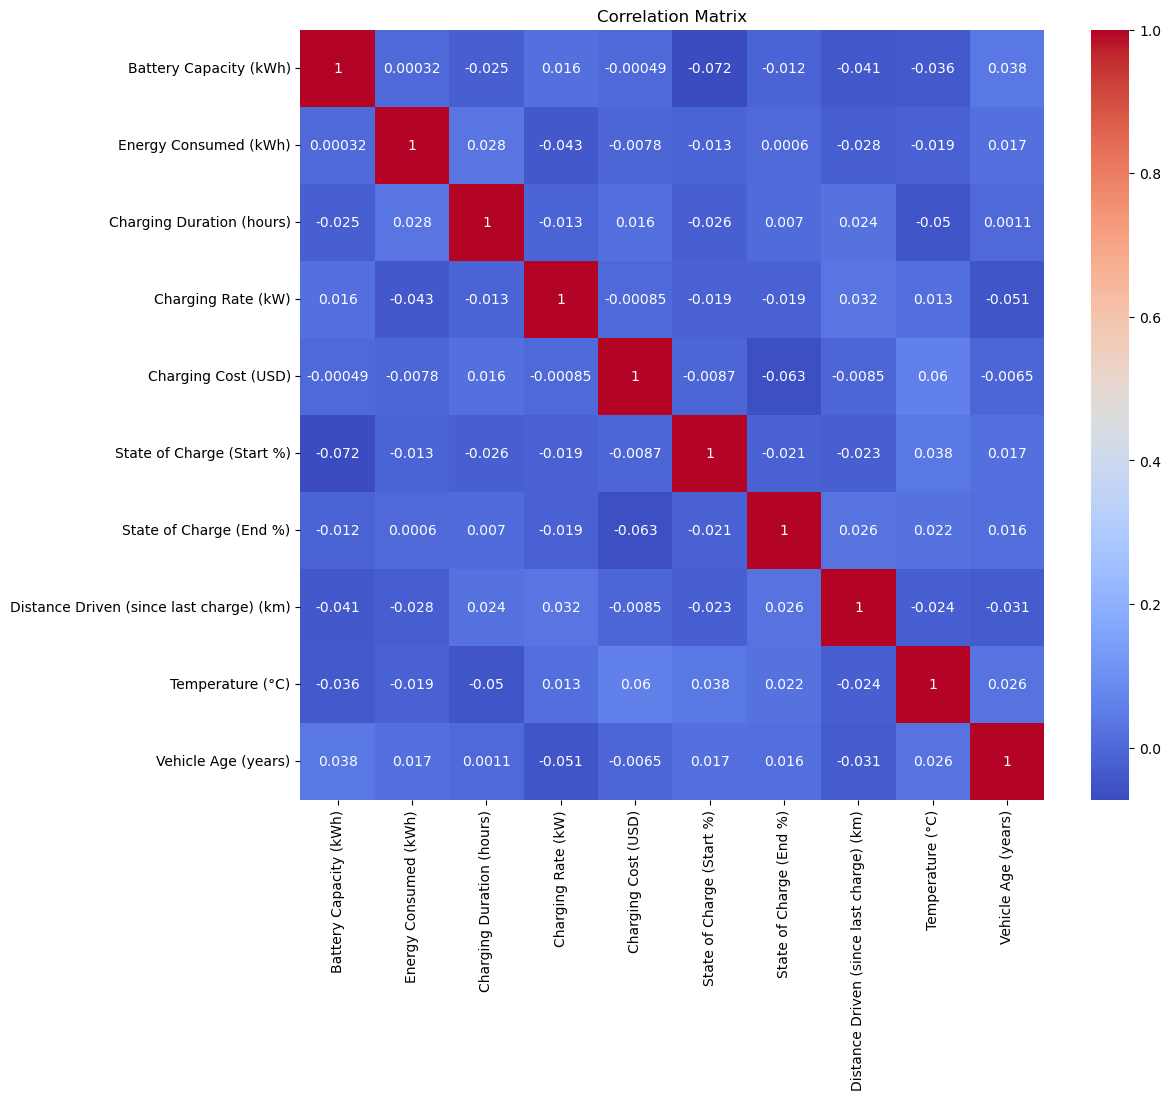

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of the target variable
sns.countplot(data=df, x='User Type')
plt.title('Distribution of User Types')
plt.show()

# Correlation heatmap for numerical features
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = df[numeric_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [3]:
# Convert 'Charging Start Time' to datetime
df['Charging Start Time'] = pd.to_datetime(df['Charging Start Time'])

# Extract hour, day of week, and weekend indicator
df['hour'] = df['Charging Start Time'].dt.hour
df['day_of_week'] = df['Charging Start Time'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Drop original datetime column if not needed
df.drop('Charging Start Time', axis=1, inplace=True)


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

# Tách target
y = df['User Type']
X = df.drop('User Type', axis=1)

# Phân tách cột số và cột phân loại
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

# Impute cột số
imputer = KNNImputer()
X_num_imputed = pd.DataFrame(imputer.fit_transform(X[num_cols]), columns=num_cols)

# Gộp lại cùng cột phân loại
X_cleaned = pd.concat([X_num_imputed, X[cat_cols].reset_index(drop=True)], axis=1)


In [9]:
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

# 1. Tách target
y = df['User Type']
X = df.drop(columns=['User Type'])

# 2. Tách cột số và phân loại
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include='object').columns

# 3. Impute cột số
imputer = KNNImputer()
X_num_imputed = pd.DataFrame(imputer.fit_transform(X[num_cols]), columns=num_cols)

# 4. Encode cột phân loại
encoder = TargetEncoder(cols=cat_cols)
X_cat_encoded = encoder.fit_transform(X[cat_cols], y)

# 5. Ghép lại dữ liệu
X_processed = pd.concat([X_num_imputed, X_cat_encoded], axis=1)

# 6. Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_processed)

# 7. Chia train-test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

# Initialize model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Cross-validation
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Average CV score: {cv_scores.mean():.4f}")

# Train
log_reg.fit(X_train, y_train)

# Predict
y_pred = log_reg.predict(X_test)

# Evaluate
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Cross-validation scores: [0.99528302 1.         1.         1.         0.99526066]
Average CV score: 0.9981

Classification Report:
                        precision    recall  f1-score   support

         Casual Driver       1.00      1.00      1.00        82
              Commuter       1.00      1.00      1.00        95
Long-Distance Traveler       1.00      1.00      1.00        87

              accuracy                           1.00       264
             macro avg       1.00      1.00      1.00       264
          weighted avg       1.00      1.00      1.00       264



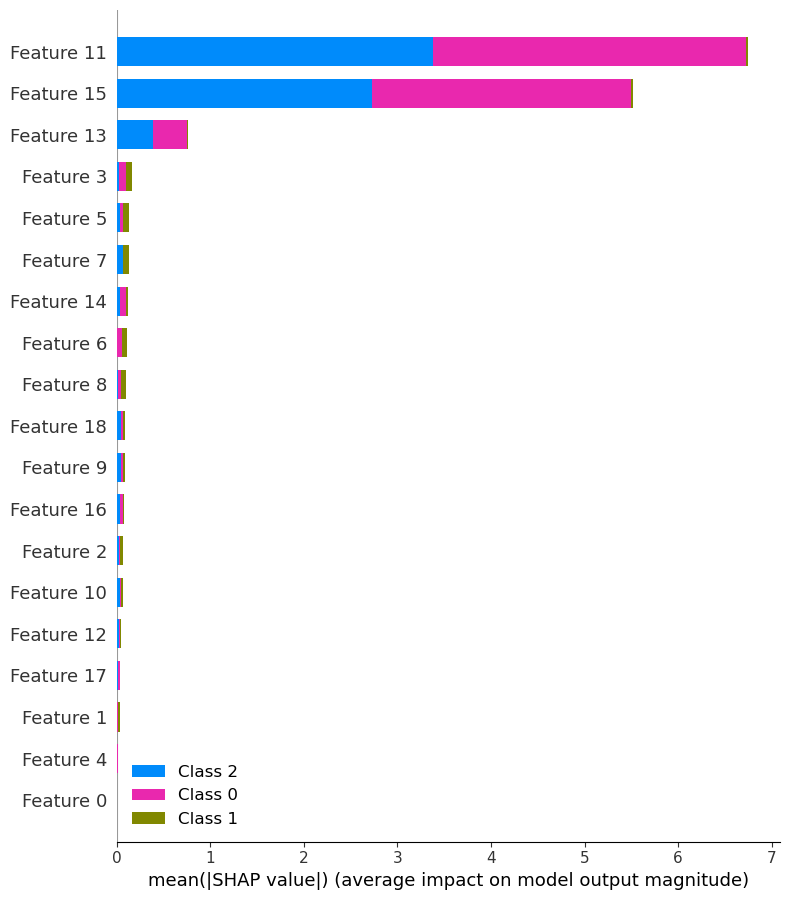

In [11]:
import shap

# Initialize SHAP explainer
explainer = shap.Explainer(log_reg, X_train)

# Calculate SHAP values
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)


In [13]:
from catboost import CatBoostClassifier

# Tạo và huấn luyện mô hình CatBoost
catboost_model = CatBoostClassifier(verbose=0, random_state=42)
catboost_model.fit(X_train, y_train)


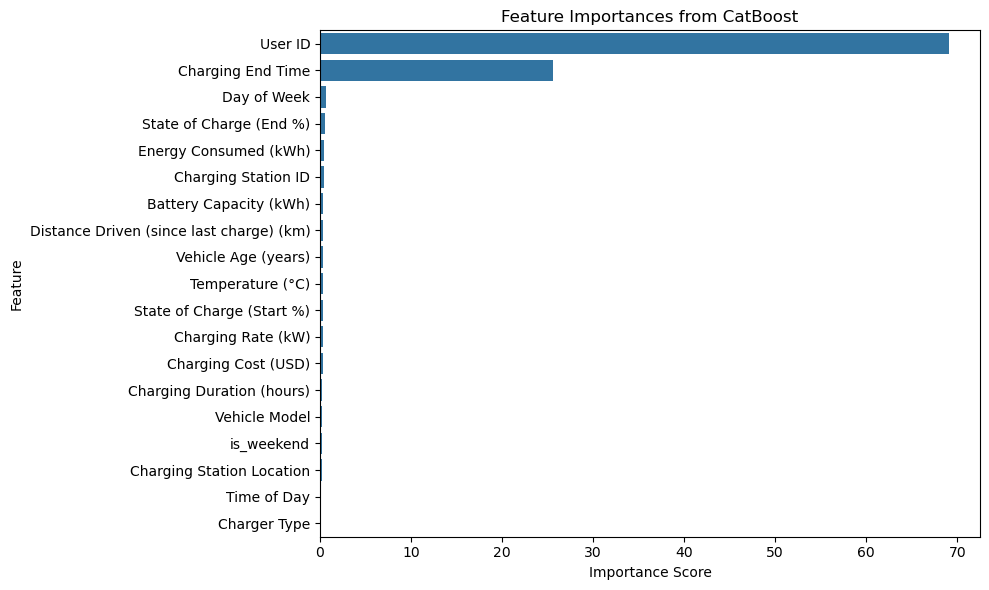

In [15]:
# Lấy tên cột từ dữ liệu đã xử lý
feature_names = X_processed.columns

# Lấy độ quan trọng của đặc trưng
importances = catboost_model.get_feature_importance()
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Vẽ biểu đồ
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances.sort_values(by='Importance', ascending=False),
            x='Importance', y='Feature')
plt.title('Feature Importances from CatBoost')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


🔍 Logistic Regression Evaluation:
                        precision    recall  f1-score   support

         Casual Driver       1.00      1.00      1.00        82
              Commuter       1.00      1.00      1.00        95
Long-Distance Traveler       1.00      1.00      1.00        87

              accuracy                           1.00       264
             macro avg       1.00      1.00      1.00       264
          weighted avg       1.00      1.00      1.00       264

Confusion Matrix - Logistic Regression:


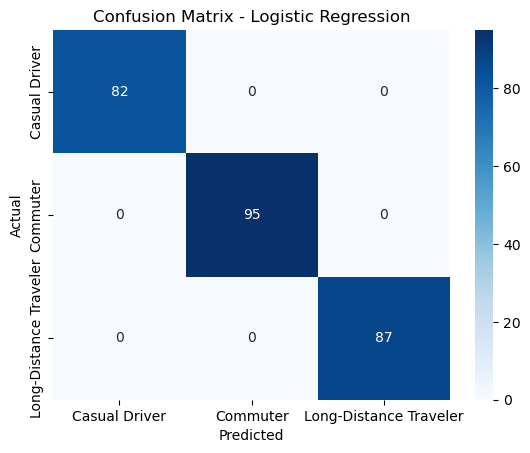


🔍 CatBoost Evaluation:
                        precision    recall  f1-score   support

         Casual Driver       1.00      1.00      1.00        82
              Commuter       1.00      1.00      1.00        95
Long-Distance Traveler       1.00      1.00      1.00        87

              accuracy                           1.00       264
             macro avg       1.00      1.00      1.00       264
          weighted avg       1.00      1.00      1.00       264

Confusion Matrix - CatBoost:


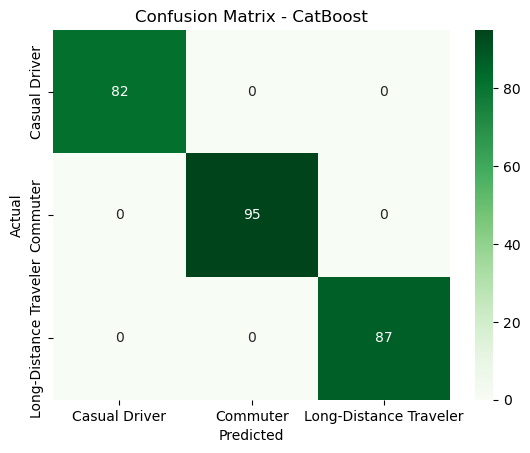


✅ F1-score Comparison:
Logistic Regression: 1.0000
CatBoost: 1.0000

👉 Dựa trên F1-score, chọn **Logistic Regression** để triển khai.


In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Đánh giá Logistic Regression
print("🔍 Logistic Regression Evaluation:")
log_pred = log_reg.predict(X_test)

print(classification_report(y_test, log_pred))
print("Confusion Matrix - Logistic Regression:")
cm_log = confusion_matrix(y_test, log_pred)
sns.heatmap(cm_log, annot=True, fmt="d", cmap="Blues", xticklabels=log_reg.classes_, yticklabels=log_reg.classes_)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ✅ Đánh giá CatBoost
print("\n🔍 CatBoost Evaluation:")
cb_pred = catboost_model.predict(X_test)

print(classification_report(y_test, cb_pred))
print("Confusion Matrix - CatBoost:")
cm_cb = confusion_matrix(y_test, cb_pred)
sns.heatmap(cm_cb, annot=True, fmt="d", cmap="Greens", xticklabels=catboost_model.classes_, yticklabels=catboost_model.classes_)
plt.title("Confusion Matrix - CatBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ✅ So sánh tổng quan giữa hai mô hình
log_f1 = f1_score(y_test, log_pred, average='weighted')
cb_f1 = f1_score(y_test, cb_pred, average='weighted')

print("\n✅ F1-score Comparison:")
print(f"Logistic Regression: {log_f1:.4f}")
print(f"CatBoost: {cb_f1:.4f}")

# ✅ Kết luận chọn mô hình
if cb_f1 > log_f1:
    print("\n👉 Dựa trên F1-score, chọn **CatBoost** để triển khai.")
else:
    print("\n👉 Dựa trên F1-score, chọn **Logistic Regression** để triển khai.")
